In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rt-iot2022/RT_IOT2022.csv


In [2]:
import pandas as pd
from sklearn.utils import resample

# Load the dataset
file_path = "/kaggle/input/rt-iot2022/RT_IOT2022.csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Separate majority and minority classes
df_majority = df[df["Attack_type"] == "DOS_SYN_Hping"]
df_minority = df[df["Attack_type"] != "DOS_SYN_Hping"]

# Undersample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,  # No replacement
                                   n_samples=int(len(df_minority) * 0.5),  # Reduce to 50% of minority size
                                   random_state=42)

# Oversample the minority classes
df_minority_upsampled = resample(df_minority, 
                                 replace=True,  # Allow duplication
                                 n_samples=int(len(df_majority_downsampled) * 0.7),  # Increase minority size
                                 random_state=42)

# Combine the balanced dataset
df_balanced = pd.concat([df_majority_downsampled, df_minority_upsampled])

# Check new class distribution
print(df_balanced["Attack_type"].value_counts(normalize=True))

# Save the balanced dataset for further processing
df_balanced.to_csv("/kaggle/working/RT_IOT2022_balanced.csv", index=False)


Attack_type
DOS_SYN_Hping                 0.588243
Thing_Speak                   0.116830
ARP_poisioning                0.111497
MQTT_Publish                  0.059614
NMAP_UDP_SCAN                 0.036670
NMAP_XMAS_TREE_SCAN           0.030923
NMAP_OS_DETECTION             0.027823
NMAP_TCP_scan                 0.015916
DDOS_Slowloris                0.007689
Wipro_bulb                    0.003927
Metasploit_Brute_Force_SSH    0.000537
NMAP_FIN_SCAN                 0.000331
Name: proportion, dtype: float64


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Identify categorical columns
categorical_cols = ["proto", "service"]  # Add more if needed

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_balanced[col] = le.fit_transform(df_balanced[col])
    label_encoders[col] = le  # Store encoders for later use

# Encode target labels
label_encoder = LabelEncoder()
df_balanced["Attack_type"] = label_encoder.fit_transform(df_balanced["Attack_type"])

# Separate features and target
X = df_balanced.drop(columns=["Attack_type"])
y = df_balanced["Attack_type"]

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert data into LSTM-compatible sequences
sequence_length = 10  # Adjust based on data patterns
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i : i + sequence_length])
    y_sequences.append(y.iloc[i + sequence_length])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Print final shapes
print("X shape:", X_sequences.shape)  # Should be (samples, timesteps, features)
print("y shape:", y_sequences.shape)  # Should be (samples,)

# Save processed data
np.save("/kaggle/working/X_sequences.npy", X_sequences)
np.save("/kaggle/working/y_sequences.npy", y_sequences)


X shape: (24179, 10, 84)
y shape: (24179,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 87s 38ms/step - accuracy: 0.3450 - f1_score: 0.3285 - loss: 1.7454 - val_accuracy: 0.6600 - val_f1_score: 0.1437 - val_loss: 0.8722 - learning_rate: 5.0000e-04
Epoch 2/20
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.5206 - f1_score: 0.5042 - loss: 1.2069 - val_accuracy: 0.6390 - val_f1_score: 0.1486 - val_loss: 0.9020 - learning_rate: 5.0000e-04
Epoch 3/20
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.6177 - f1_score: 0.5948 - loss: 0.9803 - val_accuracy: 0.6388 - val_f1_score: 0.1470 - val_loss: 0.9937 - learning_rate: 5.0000e-04
Epoch 4/20
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.6851 - f1_score: 0.6618 - loss: 0.7942 - val_accuracy: 0.6330 - val_f1_score: 0.1376 - val_loss: 1.0627 - learning_rate: 5.0000e-04
Epoch 5/20
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 80s 38ms/step - accuracy: 0.7266 - f1_score: 0.7075 - loss: 0.6785 - val_accuracy: 0.6282 - val_f1_score: 0.1370 - val_loss: 1.2144 - learning_rate: 5

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 10, 256)             │         218,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 10, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,323,110 (5.05 MB)

 Trainable params: 441,036 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 882,074 (3.36 MB)

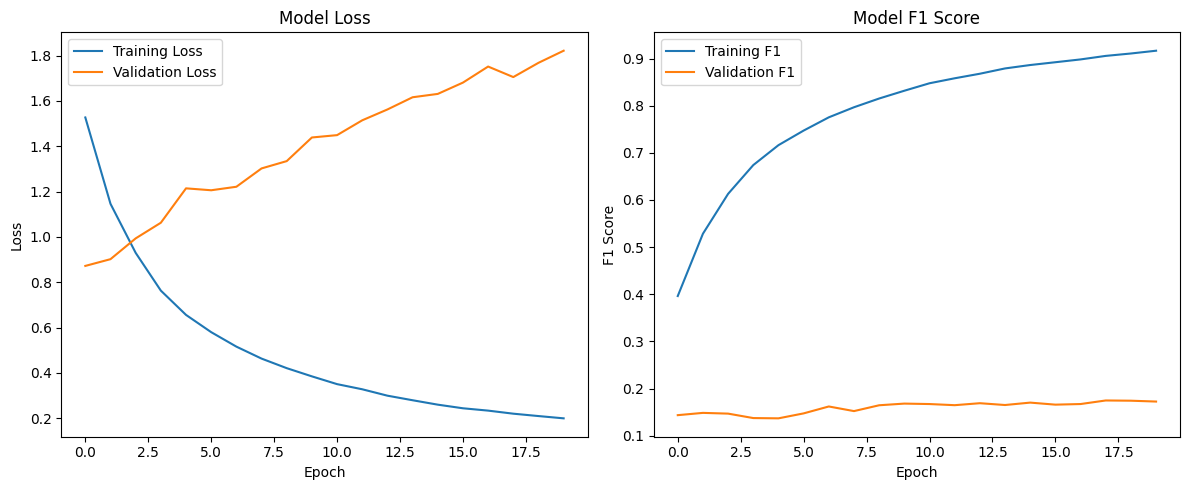

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import F1Score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load preprocessed data
X_sequences = np.load("/kaggle/working/X_sequences.npy")
y_sequences = np.load("/kaggle/working/y_sequences.npy")

# Get number of classes
num_classes = len(np.unique(y_sequences))

# Split data before applying SMOTE (to prevent data leakage)
X_train, X_val, y_train, y_val = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

# Reshape data for SMOTE (which expects 2D input)
original_shape = X_train.shape
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# Reshape back to original 3D shape for LSTM
X_train_resampled = X_train_resampled.reshape(-1, original_shape[1], original_shape[2])

# Convert labels to categorical (one-hot encoding)
y_train_categorical = tf.keras.utils.to_categorical(y_train_resampled, num_classes=num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Compute class weights as additional protection against imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Build an improved LSTM model with more capacity
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(original_shape[1], original_shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(num_classes, activation="softmax")
])

# Compile the model with better metrics
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy", F1Score(average='macro', name='f1_score')]
)

# More sophisticated callbacks - Updated file path to use .keras extension
model_checkpoint = ModelCheckpoint(
    "/kaggle/working/best_model.keras",  # Changed extension from .h5 to .keras
    monitor="val_f1_score",
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor="val_f1_score", 
    patience=10, 
    restore_best_weights=True,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_f1_score", 
    factor=0.5, 
    patience=5, 
    min_lr=0.00001,
    mode='max'
)

# Train the model
history = model.fit(
    X_train_resampled, y_train_categorical,
    epochs=20,  # Increased epochs with early stopping
    batch_size=64,  # Adjusted batch size
    validation_data=(X_val, y_val_categorical),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weight_dict
)

# Load the best model for evaluation - Updated file path
best_model = tf.keras.models.load_model("/kaggle/working/best_model.keras")

# Evaluate the model
print("Evaluating on validation data:")
best_model.evaluate(X_val, y_val_categorical)

# More detailed evaluation with sklearn
from sklearn.metrics import classification_report, confusion_matrix

y_pred = best_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val_categorical, axis=1)

print("\nClassification Report:")
print(classification_report(y_val_classes, y_pred_classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val_classes, y_pred_classes))

# Save the final model - Updated file path
best_model.save("/kaggle/working/lstm_intrusion_detection_improved.keras")

# Print model summary
best_model.summary()

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Training F1')
plt.plot(history.history['val_f1_score'], label='Validation F1')
plt.title('Model F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png')
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import F1Score, Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow.keras.backend as K

# Load preprocessed data
X_sequences = np.load("/kaggle/working/X_sequences.npy")
y_sequences = np.load("/kaggle/working/y_sequences.npy")

# Get number of classes
num_classes = len(np.unique(y_sequences))

# Split data before applying SMOTE (to prevent data leakage)
X_train, X_val, y_train, y_val = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences
)

# Reshape data for SMOTE (which expects 2D input)
original_shape = X_train.shape
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

# Reshape back to original 3D shape for LSTM
X_train_resampled = X_train_resampled.reshape(-1, original_shape[1], original_shape[2])

# Convert labels to categorical (one-hot encoding)
y_train_categorical = tf.keras.utils.to_categorical(y_train_resampled, num_classes=num_classes)
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)

# Compute class weights as additional protection against imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Temperature parameter for knowledge distillation
temperature = 5

# 1. First train a large "teacher" model
def create_teacher_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.3),
        Dense(256, activation="relu"),
        Dropout(0.4),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(num_classes, activation="softmax", name="teacher_pred")
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="categorical_crossentropy",
        metrics=["accuracy", F1Score(average='macro', name='f1_score'),
                Precision(name='precision'), Recall(name='recall')]
    )
    return model

# Create and train teacher model
teacher_model = create_teacher_model((original_shape[1], original_shape[2]), num_classes)
print("Teacher model summary:")
teacher_model.summary()

# Callbacks for teacher model
teacher_checkpoint = ModelCheckpoint(
    "/kaggle/working/teacher_model.keras",
    monitor="val_f1_score",
    save_best_only=True,
    mode='max'
)

teacher_early_stopping = EarlyStopping(
    monitor="val_f1_score", 
    patience=10, 
    restore_best_weights=True,
    mode='max'
)

teacher_reduce_lr = ReduceLROnPlateau(
    monitor="val_f1_score", 
    factor=0.5, 
    patience=5, 
    min_lr=0.00001,
    mode='max'
)

# Train the teacher model
print("\nTraining teacher model...")
teacher_history = teacher_model.fit(
    X_train_resampled, y_train_categorical,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val_categorical),
    callbacks=[teacher_early_stopping, teacher_reduce_lr, teacher_checkpoint],
    class_weight=class_weight_dict
)

# Load the best teacher model
teacher_model = tf.keras.models.load_model("/kaggle/working/teacher_model.keras")

# 2. Create a smaller "student" model
def create_student_model(input_shape, num_classes):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        LSTM(32, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dropout(0.2),
        Dense(num_classes, activation="softmax", name="student_pred")
    ])
    return model

# Create student model
student_model = create_student_model((original_shape[1], original_shape[2]), num_classes)
print("\nStudent model summary:")
student_model.summary()

# 3. Implement knowledge distillation
# Get soft targets from teacher model
print("\nGenerating soft targets from teacher model...")
teacher_soft_targets = teacher_model.predict(X_train_resampled)

# Create custom knowledge distillation model
def create_distillation_model(student_model, num_classes, temperature=5):
    """Creates a model that trains the student model with knowledge distillation"""
    # Input layer
    inputs = Input(shape=student_model.input_shape[1:])
    
    # Student model predictions
    student_logits = student_model(inputs)
    
    # Create the distillation model
    distillation_model = Model(inputs=inputs, outputs=student_logits)
    
    # Define custom loss function for knowledge distillation
    def distillation_loss(y_true, y_pred):
        # Split y_true into one-hot encoded labels and soft targets
        y_true_onehot, y_soft_targets = y_true[:, :num_classes], y_true[:, num_classes:]
        
        # Standard categorical crossentropy loss for hard targets
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true_onehot, y_pred)
        
        # Knowledge distillation loss
        # Apply temperature scaling to logits
        scaled_logits = y_pred / temperature
        scaled_soft_targets = y_soft_targets / temperature
        
        # KL divergence loss
        soft_loss = tf.keras.losses.kullback_leibler_divergence(
            tf.nn.softmax(scaled_soft_targets, axis=-1),
            tf.nn.softmax(scaled_logits, axis=-1)
        ) * (temperature ** 2)
        
        # Combine losses (alpha parameter controls balance between hard and soft targets)
        alpha = 0.7  # Weight for soft targets
        return (1 - alpha) * hard_loss + alpha * soft_loss
    
    # Compile the distillation model
    distillation_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=distillation_loss,
        metrics=["accuracy", F1Score(average='macro', name='f1_score'),
                Precision(name='precision'), Recall(name='recall')]
    )
    
    return distillation_model

# Prepare combined targets (concatenate one-hot labels and soft targets)
distillation_targets = np.concatenate([y_train_categorical, teacher_soft_targets], axis=1)

# Create distillation model
print("\nSetting up knowledge distillation...")
distillation_model = create_distillation_model(student_model, num_classes, temperature)

# Callbacks for distillation training
distill_checkpoint = ModelCheckpoint(
    "/kaggle/working/distilled_student_model.keras",
    monitor="val_f1_score",
    save_best_only=True,
    mode='max'
)

distill_early_stopping = EarlyStopping(
    monitor="val_f1_score", 
    patience=15, 
    restore_best_weights=True,
    mode='max'
)

distill_reduce_lr = ReduceLROnPlateau(
    monitor="val_f1_score", 
    factor=0.5, 
    patience=5, 
    min_lr=0.00001,
    mode='max',
    verbose=1  # Show learning rate changes
)

# Train with knowledge distillation
print("\nTraining student model with knowledge distillation...")
distillation_history = distillation_model.fit(
    X_train_resampled, distillation_targets,
    epochs=50,
    batch_size=64,
    validation_split=0.2,  # Using part of training data as validation
    callbacks=[distill_early_stopping, distill_reduce_lr, distill_checkpoint]
)

# Save the final student model architecture and weights separately
print("\nSaving final student model...")
student_json = student_model.to_json()
with open("/kaggle/working/student_model_architecture.json", "w") as json_file:
    json_file.write(student_json)
student_model.save_weights("/kaggle/working/student_model_weights.keras")

# Evaluate the student model on validation data
print("\nEvaluating student model on validation data...")
# Need to manually forward the data through the student model
student_preds = student_model.predict(X_val)
student_pred_classes = np.argmax(student_preds, axis=1)
y_val_classes = np.argmax(y_val_categorical, axis=1)

# Print classification report
print("\nStudent Model Classification Report:")
student_report = classification_report(y_val_classes, student_pred_classes, output_dict=True)
print(classification_report(y_val_classes, student_pred_classes))

# Compare with teacher model
print("\nEvaluating teacher model on validation data...")
teacher_preds = teacher_model.predict(X_val)
teacher_pred_classes = np.argmax(teacher_preds, axis=1)

print("\nTeacher Model Classification Report:")
teacher_report = classification_report(y_val_classes, teacher_pred_classes, output_dict=True)
print(classification_report(y_val_classes, teacher_pred_classes))

# Calculate confusion matrices
student_cm = confusion_matrix(y_val_classes, student_pred_classes)
teacher_cm = confusion_matrix(y_val_classes, teacher_pred_classes)

# Get model size
def get_model_size(model):
    """Estimate model size in MB"""
    # This is a simplified estimation
    return sum(np.prod(K.get_value(w).shape) for w in model.trainable_weights) * 4 / (1024 * 1024)

teacher_size = get_model_size(teacher_model)
student_size = get_model_size(student_model)

# =================== COMPREHENSIVE EVALUATION VISUALIZATIONS ===================

# Create a directory for visualizations
import os
os.makedirs("/kaggle/working/evaluation_plots", exist_ok=True)

# 1. Confusion Matrix Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(teacher_cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), 
            yticklabels=np.unique(y_val), cbar=False)
plt.title("Teacher Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(student_cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), 
            yticklabels=np.unique(y_val), cbar=False)
plt.title("Student Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.savefig('/kaggle/working/evaluation_plots/confusion_matrices.png')
plt.close()

# 2. Learning Rate Graph (using the history from distillation training)
# Extract learning rates from the distillation history
if hasattr(distillation_history, 'history') and 'lr' in distillation_history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(distillation_history.history['lr'], marker='o')
    plt.title('Learning Rate During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.savefig('/kaggle/working/evaluation_plots/learning_rate.png')
    plt.close()

# 3. Training Metrics Graphs
plt.figure(figsize=(18, 10))

# Plot accuracy
plt.subplot(2, 2, 1)
plt.plot(distillation_history.history['accuracy'], label='Training Accuracy')
plt.plot(distillation_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Student Model: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot precision
plt.subplot(2, 2, 2)
plt.plot(distillation_history.history['precision'], label='Training Precision')
plt.plot(distillation_history.history['val_precision'], label='Validation Precision')
plt.title('Student Model: Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot recall
plt.subplot(2, 2, 3)
plt.plot(distillation_history.history['recall'], label='Training Recall')
plt.plot(distillation_history.history['val_recall'], label='Validation Recall')
plt.title('Student Model: Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot F1 score
plt.subplot(2, 2, 4)
plt.plot(distillation_history.history['f1_score'], label='Training F1 Score')
plt.plot(distillation_history.history['val_f1_score'], label='Validation F1 Score')
plt.title('Student Model: F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('/kaggle/working/evaluation_plots/training_metrics.png')
plt.close()

# 4. Class-wise Metrics Comparison
# Extract class-wise metrics from classification reports
classes = np.unique(y_val).tolist()
metrics = ['precision', 'recall', 'f1-score']

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(3, 1, i+1)
    
    teacher_values = [teacher_report[str(c)][metric] if str(c) in teacher_report else 0 for c in classes]
    student_values = [student_report[str(c)][metric] if str(c) in student_report else 0 for c in classes]
    
    width = 0.35
    x = np.arange(len(classes))
    
    plt.bar(x - width/2, teacher_values, width, label='Teacher', alpha=0.7)
    plt.bar(x + width/2, student_values, width, label='Student', alpha=0.7)
    
    plt.title(f'Class-wise {metric.capitalize()} Comparison')
    plt.xlabel('Class')
    plt.ylabel(metric.capitalize())
    plt.xticks(x, classes)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6, axis='y')

plt.tight_layout()
plt.savefig('/kaggle/working/evaluation_plots/class_metrics_comparison.png')
plt.close()

# 5. Model Size Comparison
plt.figure(figsize=(8, 6))
sizes = [teacher_size, student_size]
models = ['Teacher Model', 'Student Model']
colors = ['blue', 'green']

plt.bar(models, sizes, color=colors, alpha=0.7)
plt.title('Model Size Comparison')
plt.ylabel('Size (MB)')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add size values on top of bars
for i, v in enumerate(sizes):
    plt.text(i, v + 0.1, f"{v:.2f} MB", ha='center')

# Add size reduction as text
reduction = (1 - student_size/teacher_size) * 100
plt.text(0.5, max(sizes) * 0.5, f"Size reduction: {reduction:.1f}%", 
         ha='center', bbox=dict(facecolor='white', alpha=0.8))

plt.savefig('/kaggle/working/evaluation_plots/model_size_comparison.png')
plt.close()

# 6. ROC Curves and AUC for each class
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15, 10))

# Generate a color map for the classes
colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))

for i, c in enumerate(np.unique(y_val)):
    # Skip if there are no instances of this class
    if str(c) not in student_report:
        continue
        
    # For each class, treat it as a binary classification problem
    y_true_binary = (y_val_classes == c).astype(int)
    
    # Teacher model predictions
    teacher_probs = teacher_preds[:, c]
    teacher_fpr, teacher_tpr, _ = roc_curve(y_true_binary, teacher_probs)
    teacher_auc_score = auc(teacher_fpr, teacher_tpr)
    
    # Student model predictions
    student_probs = student_preds[:, c]
    student_fpr, student_tpr, _ = roc_curve(y_true_binary, student_probs)
    student_auc_score = auc(student_fpr, student_tpr)
    
    plt.plot(teacher_fpr, teacher_tpr, color=colors[i], linestyle='-', 
             label=f'Class {c} - Teacher (AUC = {teacher_auc_score:.2f})', alpha=0.7)
    plt.plot(student_fpr, student_tpr, color=colors[i], linestyle='--', 
             label=f'Class {c} - Student (AUC = {student_auc_score:.2f})', alpha=0.7)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='best', fontsize='small')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('/kaggle/working/evaluation_plots/roc_curves.png')
plt.close()

# 7. Summary Metrics Dashboard
plt.figure(figsize=(15, 10))

# Get overall metrics
teacher_macro = [teacher_report['macro avg'][m] for m in metrics]
student_macro = [student_report['macro avg'][m] for m in metrics]
teacher_weighted = [teacher_report['weighted avg'][m] for m in metrics]
student_weighted = [student_report['weighted avg'][m] for m in metrics]

# Plot macro avg metrics
plt.subplot(2, 1, 1)
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, teacher_macro, width, label='Teacher', color='blue', alpha=0.7)
plt.bar(x + width/2, student_macro, width, label='Student', color='green', alpha=0.7)

plt.title('Macro Average Metrics')
plt.xticks(x, [m.capitalize() for m in metrics])
plt.ylabel('Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

# Add values on bars
for i, v in enumerate(teacher_macro):
    plt.text(i - width/2, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
for i, v in enumerate(student_macro):
    plt.text(i + width/2, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=9)

# Plot weighted avg metrics
plt.subplot(2, 1, 2)
plt.bar(x - width/2, teacher_weighted, width, label='Teacher', color='blue', alpha=0.7)
plt.bar(x + width/2, student_weighted, width, label='Student', color='green', alpha=0.7)

plt.title('Weighted Average Metrics')
plt.xticks(x, [m.capitalize() for m in metrics])
plt.ylabel('Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6, axis='y')

# Add values on bars
for i, v in enumerate(teacher_weighted):
    plt.text(i - width/2, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=9)
for i, v in enumerate(student_weighted):
    plt.text(i + width/2, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/kaggle/working/evaluation_plots/summary_metrics.png')
plt.close()

# Print summary comparison
print("\n===== MODEL COMPARISON =====")
print(f"Teacher model parameters: {teacher_model.count_params():,}")
print(f"Student model parameters: {student_model.count_params():,}")
print(f"Size reduction: {(1 - student_model.count_params() / teacher_model.count_params()) * 100:.2f}%")

print("\nTeacher model macro F1-score:", teacher_report['macro avg']['f1-score'])
print("Student model macro F1-score:", student_report['macro avg']['f1-score'])
print(f"Performance difference: {(student_report['macro avg']['f1-score'] - teacher_report['macro avg']['f1-score']) * 100:.2f}%")

# Generate a HTML report that combines all visualizations
html_report = """
<!DOCTYPE html>
<html>
<head>
    <title>Intrusion Detection Model Evaluation</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 20px; }
        h1 { color: #2c3e50; }
        h2 { color: #3498db; margin-top: 30px; }
        .image-container { margin: 20px 0; }
        img { max-width: 100%; border: 1px solid #ddd; border-radius: 5px; }
        .metrics { display: flex; justify-content: space-around; margin: 20px 0; }
        .metric-box { text-align: center; padding: 15px; background-color: #f8f9fa; border-radius: 5px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }
        .metric-value { font-size: 24px; font-weight: bold; color: #2980b9; }
        .metric-label { font-size: 14px; color: #7f8c8d; }
    </style>
</head>
<body>
    <h1>Intrusion Detection Model Evaluation Report</h1>
    
    <div class="metrics">
        <div class="metric-box">
            <div class="metric-value">{teacher_params:,}</div>
            <div class="metric-label">Teacher Parameters</div>
        </div>
        <div class="metric-box">
            <div class="metric-value">{student_params:,}</div>
            <div class="metric-label">Student Parameters</div>
        </div>
        <div class="metric-box">
            <div class="metric-value">{size_reduction:.1f}%</div>
            <div class="metric-label">Size Reduction</div>
        </div>
        <div class="metric-box">
            <div class="metric-value">{perf_diff:.2f}%</div>
            <div class="metric-label">Performance Difference</div>
        </div>
    </div>

    <h2>Model Size Comparison</h2>
    <div class="image-container">
        <img src="model_size_comparison.png" alt="Model Size Comparison">
    </div>
    
    <h2>Confusion Matrices</h2>
    <div class="image-container">
        <img src="confusion_matrices.png" alt="Confusion Matrices">
    </div>
    
    <h2>Training Metrics</h2>
    <div class="image-container">
        <img src="training_metrics.png" alt="Training Metrics">
    </div>
    
    <h2>Learning Rate</h2>
    <div class="image-container">
        <img src="learning_rate.png" alt="Learning Rate">
    </div>
    
    <h2>Summary Metrics</h2>
    <div class="image-container">
        <img src="summary_metrics.png" alt="Summary Metrics">
    </div>
    
    <h2>Class-wise Metrics Comparison</h2>
    <div class="image-container">
        <img src="class_metrics_comparison.png" alt="Class-wise Metrics">
    </div>
    
    <h2>ROC Curves</h2>
    <div class="image-container">
        <img src="roc_curves.png" alt="ROC Curves">
    </div>
</body>
</html>
""".format(
    teacher_params=teacher_model.count_params(),
    student_params=student_model.count_params(),
    size_reduction=(1 - student_model.count_params() / teacher_model.count_params()) * 100,
    perf_diff=(student_report['macro avg']['f1-score'] - teacher_report['macro avg']['f1-score']) * 100
)

# Write HTML report
with open('/kaggle/working/evaluation_plots/evaluation_report.html', 'w') as f:
    f.write(html_report)

# Final model for deployment
print("\nSaving final optimized model for deployment...")
student_model.save("/kaggle/working/final_distilled_model.keras")

print("\nEvaluation complete! All visualizations saved to /kaggle/working/evaluation_plots/")
print("HTML report available at /kaggle/working/evaluation_plots/evaluation_report.html")

Teacher model summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional)      │ (None, 10, 512)             │         698,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 10, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 10, 256)             │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ teacher_pred (Dense)                 │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,594,060 (6.08 MB)

 Trainable params: 1,594,060 (6.08 MB)

 Non-trainable params: 0 (0.00 B)


Training teacher model...
Epoch 1/30
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 211s 95ms/step - accuracy: 0.3545 - f1_score: 0.3406 - loss: 1.7208 - precision: 0.9511 - recall: 0.2426 - val_accuracy: 0.6286 - val_f1_score: 0.1410 - val_loss: 0.8810 - val_precision: 0.9743 - val_recall: 0.5883 - learning_rate: 5.0000e-04
Epoch 2/30
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 201s 94ms/step - accuracy: 0.5560 - f1_score: 0.5406 - loss: 1.1171 - precision: 0.9572 - recall: 0.4378 - val_accuracy: 0.6398 - val_f1_score: 0.1548 - val_loss: 0.9475 - val_precision: 0.9596 - val_recall: 0.5895 - learning_rate: 5.0000e-04
Epoch 3/30
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 205s 96ms/step - accuracy: 0.6740 - f1_score: 0.6546 - loss: 0.8301 - precision: 0.9341 - recall: 0.5525 - val_accuracy: 0.6524 - val_f1_score: 0.1592 - val_loss: 1.0845 - val_precision: 0.8740 - val_recall: 0.5953 - learning_rate: 5.0000e-04
Epoch 4/30
2133/2133 ━━━━━━━━━━━━━━━━━━━━ 217s 102ms/step - accuracy: 0.7689 - f1_score: 0.7523 - loss: 0.5769 - preci